In [1]:
# %pip install validators

In [2]:
import torch
import matplotlib.pyplot as plt
import torchvision.models as models

In [3]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [4]:
print(efficientnet)

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [5]:
resnet = models.resnet50(weights="IMAGENET1K_V2")
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0039e-04.
Adjusting learning rate of group 0 to 1.0158e-04.
Adjusting learning rate of group 0 to 1.0355e-04.
Adjusting learning rate of group 0 to 1.0630e-04.
Adjusting learning rate of group 0 to 1.0985e-04.
Adjusting learning rate of group 0 to 1.1418e-04.
Adjusting learning rate of group 0 to 1.1929e-04.
Adjusting learning rate of group 0 to 1.2519e-04.
Adjusting learning rate of group 0 to 1.3188e-04.
Adjusting learning rate of group 0 to 1.3935e-04.
Adjusting learning rate of group 0 to 1.4760e-04.
Adjusting learning rate of group 0 to 1.5663e-04.
Adjusting learning rate of group 0 to 1.6643e-04.
Adjusting learning rate of group 0 to 1.7702e-04.
Adjusting learning rate of group 0 to 1.8838e-04.
Adjusting learning rate of group 0 to 2.0052e-04.
Adjusting learning rate of group 0 to 2.1342e-04.
Adjusting learning rate of group 0 to 2.2710e-04.
Adjusting learning rate of group 0 to 2.4155e-04.


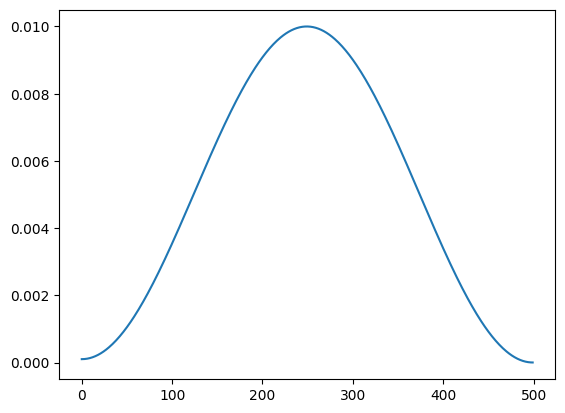

In [6]:
epochs = 500
initial_lr = 0.0001
max_lr = 0.01
div_factor = max_lr / initial_lr
final_div_factor = max_lr / 0.0001  # 0.0001을 마지막 lr로 사용하고자 함

model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=max_lr, 
                                                div_factor=div_factor,
                                                final_div_factor=final_div_factor,
                                                total_steps=epochs,
                                                anneal_strategy="cos",
                                                pct_start=0.5,
                                                three_phase=False,  # 학습률을 파괴하는 세 번째 단계는 필요하지 않습니다.
                                                verbose=True)

lrs = []
for i in range(epochs):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(lrs)
plt.show()


In [7]:
import cv2
import random
import numpy as np
import albumentations as A

from torch.utils.data import Dataset

class BKAIDataset(Dataset):
    def __init__(self, base_dir, split, size):
        super().__init__()
        self.base_dir = base_dir
        self.split = split
        self.size = size

        self.set_txt = f"{base_dir}/{split}.txt"
        with open(self.set_txt, "r") as f:
            file_list = f.readlines()

        self.file_list = [x.strip() for x in file_list]

    
    def load_img_mask(self, index):
        file_name = self.file_list[index]
        image = cv2.imread(f"{self.base_dir}/train/{file_name}.jpeg")
        mask = cv2.imread(f"{self.base_dir}/train_mask/{file_name}.jpeg") 
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        image = cv2.resize(image, (self.size, self.size))
        mask = cv2.resize(mask, (self.size, self.size))

        return image, mask
        

    def __getitem__(self, index):
        image, mask = self.load_img_mask(index)

        if self.split == "train":
            prob = random.random()
            if prob < 0.3:
                transform_image, transform_mask = self.train_transform(image, mask)

            elif 0.3 < prob < 0.6:
                transform_image, transform_mask = self.mosaic_augmentation(image, mask)

            else:
                transform_image, transform_mask = self.cutmix_augmentation(image, mask)

            # if random.random() > 0.5:
            #     transform_image = self.image_transform(image)
        
        else:
            transform_image, transform_mask = self.valid_transform(image, mask)
        
        # transform_image = np.transpose(transform_image, (2, 0, 1)) ## H, W, C -> C, H, W
        # transform_image = transform_image / 255.0

        # transform_mask = self.encode_mask(transform_mask)

        return transform_image, transform_mask
    

    def __len__(self):
        return len(self.file_list)


    def encode_mask(self, mask):
        label_transformed = np.zeros(shape=mask.shape[:-1], dtype=np.uint8)

        red_mask = mask[:, :, 0] >= 100
        label_transformed[red_mask] = 1

        green_mask = mask[:, :, 1] >= 100
        label_transformed[green_mask] = 2

        return label_transformed
    

    def train_transform(self, image, mask):
        transform = A.Compose([A.Rotate(limit=90, p=0.5),
                               A.HorizontalFlip(p=0.5),
                               A.VerticalFlip(p=0.5),
                               A.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, p=0.3),
                               A.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), p=0.3),
                               A.CoarseDropout(max_holes=10, max_height=32, max_width=32, p=0.4),
                               A.ShiftScaleRotate(shift_limit_x=(-0.06, 0.06), shift_limit_y=(-0.06, 0.06), scale_limit=(-0.3, 0.1), rotate_limit=(-90, 90), border_mode=0, value=(0, 0, 0), p=0.4)])        
        
        transformed = transform(image=image, mask=mask)
        transformed_image, transformed_mask = transformed["image"], transformed["mask"]

        return transformed_image, transformed_mask
    

    def valid_transform(self, image, mask):
        transform = A.Compose([A.Resize(self.size, self.size, p=1)])
        
        transformed = transform(image=image, mask=mask)
        transformed_image = transformed['image']
        transformed_mask = transformed['mask']

        return transformed_image, transformed_mask
    

    def mosaic_augmentation(self, image, mask):
        h, w = self.size, self.size
        mosaic_img = np.zeros((h, w, 3), dtype=np.uint8)
        mosaic_mask = np.zeros((h, w, 3), dtype=np.uint8)
        cx, cy = random.randint(w//4, 3*w//4), random.randint(h//4, 3*h//4)

        candidates = []
        is_full = False
        while not is_full:
            idx = random.randint(0, len(self.file_list)-1)

            if not idx in candidates:
                candidates.append(idx)

            if len(candidates) < 4:
                is_full = True
        
        indices = [0, 1, 2, 3]
        random.shuffle(indices)
        for i, index in enumerate(indices):
            image, mask = self.load_img_mask(index)
            
            if i == 0:
                mosaic_img[:cy, :cx] = cv2.resize(image, (cx, cy))
                mosaic_mask[:cy, :cx] = cv2.resize(mask, (cx, cy))
            elif i == 1:
                mosaic_img[:cy, cx:] = cv2.resize(image, (w-cx, cy))
                mosaic_mask[:cy, cx:] = cv2.resize(mask, (w-cx, cy))
            elif i == 2:
                mosaic_img[cy:, :cx] = cv2.resize(image, (cx, h-cy))
                mosaic_mask[cy:, :cx] = cv2.resize(mask, (cx, h-cy))
            elif i == 3:
                mosaic_img[cy:, cx:] = cv2.resize(image, (w-cx, h-cy))
                mosaic_mask[cy:, cx:] = cv2.resize(mask, (w-cx, h-cy))
        
        return mosaic_img, mosaic_mask


    def image_transform(self, image):
        transform = A.Compose([A.Blur(p=0.5),
                               A.RandomBrightnessContrast(p=0.5),
                               A.CLAHE(p=0.3)])        
        
        transformed = transform(image=image)
        transformed_image = transformed["image"]

        return transformed_image
    

    def cutmix_augmentation(self, image, mask):
        idx = random.randint(0, len(self.file_list) - 1)
        mix_image, mix_mask = self.load_img_mask(idx)

        lam = np.clip(np.random.beta(1.0, 1.0), 0.2, 0.8)
        bbx1, bby1, bbx2, bby2 = self.rand_bbox(image.shape, lam)

        image[bbx1:bbx2, bby1:bby2] = mix_image[bbx1:bbx2, bby1:bby2]
        mask[bbx1:bbx2, bby1:bby2] = mix_mask[bbx1:bbx2, bby1:bby2]

        return image, mask


    def rand_bbox(self, size, lam):
        W = size[1]
        H = size[0]
        cut_rat = np.sqrt(1. - lam)
        cut_w = np.int64(W * cut_rat)
        cut_h = np.int64(H * cut_rat)

        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2

In [8]:
import os
import yaml
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

with open("/home/pervinco/DL-workspace/BKAI_IGH_NeoPolyp/config.yaml", "r") as f:
    config = yaml.safe_load(f)

## Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = min([os.cpu_count(), config["batch_size"] if config["batch_size"] > 1 else 0, 8])

## Load Dataset
train_dataset = BKAIDataset(config["data_dir"], split="train", size=config["img_size"])
valid_dataset = BKAIDataset(config["data_dir"], split="valid", size=config["img_size"])

train_dataloader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True, num_workers=num_workers)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=1, num_workers=num_workers)

(256, 256, 3) (256, 256, 3)


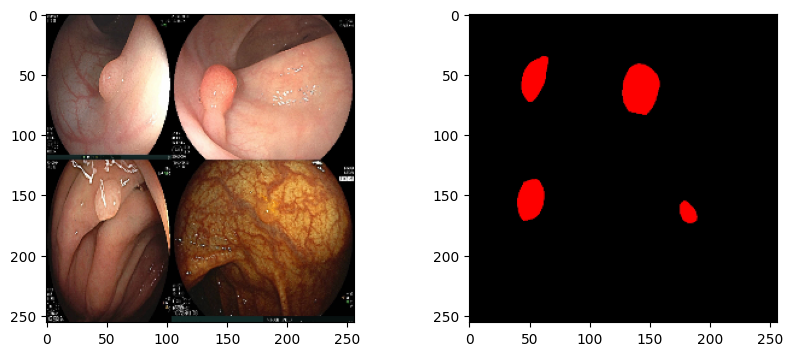

In [28]:
for image, mask in train_dataloader:
    image = image.numpy()[0]
    mask = mask.numpy()[0]
    print(image.shape, mask.shape)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.imshow(mask)

    break

In [38]:
import torch
from efficientnet_pytorch import EfficientNet

class FeatureExtractor:
    def __init__(self, model):
        self.model = model
        self.features = []
        self.names = []

    def hook_fn(self, module, input, output):
        self.features.append(output.shape)

    def register_hooks(self, layers, model=None, parent_name=""):
        if model is None:
            model = self.model

        for name, layer in model.named_children():
            full_name = f"{parent_name}.{name}" if parent_name else name
            if name in layers:
                layer.register_forward_hook(self.hook_fn)
                self.names.append(full_name)
            self.register_hooks(layers, model=layer, parent_name=full_name)

    def __call__(self, x):
        self.model(x)
        return self.names, self.features

model = EfficientNet.from_pretrained('efficientnet-b0')
layers_to_monitor = [
    '_conv_stem', '_bn0', 
    '_blocks', # This will add a lot of entries, as it's a module list. 
    '_conv_head', '_bn1', 
    '_fc'
]

x = torch.randn(1, 3, 224, 224)
extractor = FeatureExtractor(model)
extractor.register_hooks(layers_to_monitor)
names, output_shapes = extractor(x)

for name, shape in zip(names, output_shapes):
    print(f"Layer {name}: {shape}")


Loaded pretrained weights for efficientnet-b0
Layer _conv_stem: torch.Size([1, 32, 112, 112])
Layer _bn0: torch.Size([1, 32, 112, 112])
Layer _blocks: torch.Size([1, 32, 112, 112])
Layer _blocks.0._bn1: torch.Size([1, 96, 112, 112])
Layer _blocks.1._bn0: torch.Size([1, 96, 56, 56])
Layer _blocks.1._bn1: torch.Size([1, 144, 56, 56])
Layer _blocks.2._bn0: torch.Size([1, 144, 56, 56])
Layer _blocks.2._bn1: torch.Size([1, 144, 56, 56])
Layer _blocks.3._bn0: torch.Size([1, 144, 28, 28])
Layer _blocks.3._bn1: torch.Size([1, 240, 28, 28])
Layer _blocks.4._bn0: torch.Size([1, 240, 28, 28])
Layer _blocks.4._bn1: torch.Size([1, 240, 28, 28])
Layer _blocks.5._bn0: torch.Size([1, 240, 14, 14])
Layer _blocks.5._bn1: torch.Size([1, 480, 14, 14])
Layer _blocks.6._bn0: torch.Size([1, 480, 14, 14])
Layer _blocks.6._bn1: torch.Size([1, 480, 14, 14])
Layer _blocks.7._bn0: torch.Size([1, 480, 14, 14])
Layer _blocks.7._bn1: torch.Size([1, 480, 14, 14])
Layer _blocks.8._bn0: torch.Size([1, 480, 14, 14])
Lay

In [41]:
layer = model._blocks[1]
print(layer)

MBConvBlock(
  (_expand_conv): Conv2dStaticSamePadding(
    16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False
    (static_padding): Identity()
  )
  (_bn0): BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_depthwise_conv): Conv2dStaticSamePadding(
    96, 96, kernel_size=(3, 3), stride=[2, 2], groups=96, bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn1): BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_se_reduce): Conv2dStaticSamePadding(
    96, 4, kernel_size=(1, 1), stride=(1, 1)
    (static_padding): Identity()
  )
  (_se_expand): Conv2dStaticSamePadding(
    4, 96, kernel_size=(1, 1), stride=(1, 1)
    (static_padding): Identity()
  )
  (_project_conv): Conv2dStaticSamePadding(
    96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
    (static_padding): Identity()
  )
  (_bn2): BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, trac

In [40]:
print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    